# Setup

In [13]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pandas as pd
import torch_geometric
import warnings
from tqdm import tqdm
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
warnings.simplefilter("ignore")
import dgl.data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# Datasets

In [14]:
def relable(labels):
  new_l = 0
  new_labels = -1*torch.ones(labels.shape[0])
  for i,l in enumerate(labels):
    if new_labels[i]==-1:
      new_labels[labels==l]=new_l
      new_l +=1
  return new_labels.long()


def pyg_to_dgl_graph_converter(pyg_g):
  u,v = pyg_g.edge_index
  f = pyg_g.x
  labels = pyg_g.y
  g = dgl.graph((u,v))
  g.ndata['feat'] = f
  g.ndata['label'] = relable(labels)
  return g


def add_train_val_test_masks(g):
  data_len = g.ndata['label'].shape[0]
  ind = torch.tensor(range(data_len))
  perm = torch.randperm(data_len)
  split = (int(0.8*data_len), int(0.9*data_len),int(data_len))

  train_mask = torch.tensor([i in ind[:split[0]] for i in ind])[perm]
  val_mask = torch.tensor([i in ind[split[0]:split[1]] for i in ind])[perm]
  test_mask = torch.tensor([i in ind[split[1]:] for i in ind])[perm]

  g.ndata.update({'test_mask':test_mask})
  g.ndata.update({'train_mask':train_mask})
  g.ndata.update({'val_mask':val_mask})
  return g


class NewCoraGraphDataset(dgl.data.CoraGraphDataset):
    def __init__(self):
      super().__init__()

      add_train_val_test_masks(self[0])

class NewCiteseerGraphDataset(dgl.data.CiteseerGraphDataset):
    def __init__(self):
      super().__init__()

      add_train_val_test_masks(self[0])


class NewPubmedGraphDataset(dgl.data.PubmedGraphDataset):
    def __init__(self):
      super().__init__()

      add_train_val_test_masks(self[0])

class NewPPI0GraphDataset(dgl.data.PPIDataset):
    def __init__(self):
      super().__init__()
      for graph in tqdm(self):
        graph = add_train_val_test_masks(graph)


class ActorGraphDataset(dgl.data.DGLDataset):
  
  def __init__(self):
      super().__init__(name='ActorGraphDataset')
      ActorDataset = torch_geometric.datasets.Actor(os.getcwd())
      self.dg_dataset = []
      for i,pyg_graph in enumerate(tqdm(ActorDataset)):
        graph = pyg_to_dgl_graph_converter(pyg_graph)
        graph = add_train_val_test_masks(graph)
        self.dg_dataset.append(graph)
    
  def __getitem__(self,i):
    return self.dg_dataset[i]

class LINKXDatasetGraphDataset():
  
  def __init__(self):
      names = ["penn94", "reed98", "amherst41", "cornell5", "johnshopkins55"] #, "genius"
      #if name not in names:
      #  raise NotImplementedError('Please select one of "penn94", "reed98", "amherst41", "cornell5", "johnshopkins55", "genius"')
      pyg_dataset = [torch_geometric.datasets.LINKXDataset(os.getcwd(),name)[0] for name in names]
      self.dgl_dataset = []
      for i,pyg_graph in enumerate(tqdm(pyg_dataset)):
        graph = pyg_to_dgl_graph_converter(pyg_graph)
        graph = add_train_val_test_masks(graph)
        self.dgl_dataset.append(graph)
    
  def __getitem__(self,i):
    return self.dgl_dataset[i]


class AmazonDatasetGraphDataset():
  
  def __init__(self):
      names = ["Computers", "Photo"]
      pyg_dataset = [torch_geometric.datasets.Amazon(os.getcwd(),name)[0] for name in names]
      self.dgl_dataset = []
      for i,pyg_graph in enumerate(tqdm(pyg_dataset)):
        graph = pyg_to_dgl_graph_converter(pyg_graph)
        graph = add_train_val_test_masks(graph)
        self.dgl_dataset.append(graph)
    
  def __getitem__(self,i):
    return self.dgl_dataset[i]


def get_complete_graph(n0,label=1,k=1):
  u = [i//n0 for i in range(n0**2)]
  v = [i for i in range(n0)]*n0
  g0 = dgl.graph((u,v))
  g0.ndata['label'] = torch.ones(n0)*label
  if k>1:
    for i in range(k):
      g0.ndata['label'][g0.nodes()%k==i]=i
  return dgl.remove_self_loop(g0)

def get_homo_graph(n,k):
  return dgl.batch([get_complete_graph(n,label=l) for l in range(k)])

def get_unbalanced_homo_graph(n_list,k):
  return dgl.batch([get_complete_graph(n_list[l],label=l) for l in range(k)])

def get_hetero_graph(n,k):
  return dgl.batch([get_complete_graph(k,k=k)]*n)

# SBMs

In [15]:
def infer_Z(y):
  n = y.shape[0]
  v = np.arange(n)
  Z = torch.sparse_coo_tensor((v,y),torch.ones(n)).to_dense()
  return Z


def sbm_naive(g):
  A = g.adj().to_dense()
  y = g.ndata['label']
  n = y.shape[0]
  Z = infer_Z(y)
  ni = torch.diag(Z.T@Z)
  Ni_inv = torch.diag(1/ni)
  Pi = ni.diag()/n
  S = (Z.T@A@Z)
  B = Ni_inv@Z.T@A@Z@Ni_inv*n
  return S, B, Pi


def sbm_MLE(g):
  A = g.adj().to_dense()
  y = g.ndata['label']
  n = y.shape[0]
  k = y.unique().shape[0]
  Z = infer_Z(y)

  u = torch.ones(n)
  U = torch.outer(u,u)#-torch.eye(n)

  Pi = (Z.T@u).diag()/n
  
  B = Z.T@A@Z*n/(Z.T@U@Z)
  S = Pi@B
  return S, B, Pi

# Graph Coarsening

In [16]:
def spectral_weights(l,Q,d,Pi,mu,a,p):
  K =Pi.shape[0]
  W = torch.stack([torch.trace(torch.outer(Pi**(1/2)@q,Pi**(1/2)@q))for q in Q.T])
  d_approx = (l*W).sum()
  g = lambda k: np.exp(-a*abs(k-mu)**(p))/sum([np.exp(-a*abs(i-mu)**(p))*W[i] for i in range(K-1)])
  h_k = torch.stack([(d_approx)/l[k] * g(k)*(1-l[-1]*W[-1]/d_approx) for k in range(K-1)]+[torch.tensor(1)])
  #print('g(2): ', g(2))
  #print('d: ', d)
  #print('l: ', l)
  #print('W: ', W)
  #print('h_k: ', h_k)
  #print('l*W*h_k: ', (l*W*h_k).sum())
  #print('l*W: ', (l*W).sum())
  return h_k


def generate_Z(Pi,n):
  k = Pi.shape[0]
  u = np.ones(n)
  Pi_repeated = np.outer(u,Pi.diag())
  Z = stats.bernoulli.rvs(Pi_repeated, size=(n,k))

  return Z

def coarsen(A,y):
  n = y.shape[0]
  Z = infer_Z(y)
  ni = torch.diag(Z.T@Z)
  Ni_inv = torch.diag(1/ni)
  Pi = ni.diag()/n
  B = Ni_inv.float()@Z.float().T@A.float()@Z@Ni_inv.float()
  return B, Pi

def decoarsen(B, Pi, y):
  n = y.shape[0]
  Z = infer_Z(y)
  A_p = Z@B@Z.T/n
  if not ((A_p<0)+(A_p>1)).any():
    A = stats.bernoulli.rvs(A_p, size=(n,n))
    return A
  else:
    return torch.zeros((n,n))
  

def regularise(A):
  A[A<0] = 0
  A[A>1] = 1
  
  return A

def make_graph(A,y):
  n = y.shape[0]
  g = dgl.graph(torch.where(torch.tensor(A)==1),num_nodes=n)
  g.ndata['label'] = torch.tensor(y)
  return g

def NOTWORKING_change_homophily(B,Pi,d,mu,a=0.005,p=1):
  l,Q = torch.linalg.eigh(Pi**(1/2)@B@Pi**(1/2))
  print(l.mean()/d)
  print(l)
  h_k = spectral_weights(l,Q,d,Pi,mu,a,p)
  l = h_k*l
  B_new1 = (Pi.diag()**(-1/2))*(Q@l.diag()@Q.T)*(Pi.diag()**(-1/2))
  print(l.mean()/d)
  print(l)
  return B_new1


def change_homophily(B,Pi,d,h):
  l,Q = torch.linalg.eigh(Pi**(1/2)@B@Pi**(1/2))
  l[:-1] = h*l[:-1]
  B_new = (Pi.diag()**(-1/2))*(Q@l.diag()@Q.T)*(Pi.diag()**(-1/2))
  return B_new

def gen_synthetic_graph_spectral(g,h=None,d_in = torch.tensor(-1),d_out=torch.tensor(-1)):
  
  g0 = g.clone()
  n = g.number_of_nodes()
  
  if d_out.sum()<0:
    d_out = torch.ones(n)
  
  A = g.adj().to_dense()
  
  y = g.ndata['label']
  k = y.unique().shape[0]
  feat = g.ndata['feat']
  B, Pi = coarsen(A,y)

  B = change_homophily(n*B,Pi,d_out,h)

  A = decoarsen(B, Pi, y)


  if A.any():
    g_synthetic = make_graph(A,y)
    g_synthetic.ndata['feat'] = feat
    add_train_val_test_masks(g_synthetic)
    return g_synthetic
  else:
    return None


def gen_synthetic_graph_structural(g0,h=1,N_max=10000,interval=None):
  if interval is None:
    interval = N_max//20

  g = g0.clone()
  h0 = class_homophily(g)
  n = g.number_of_nodes()
  classes = g.ndata['label'].unique()

  cnt = 0
  h_list = []
  g_list = []

  if h<h0:
    mode = -1
  else:
    mode = 1
  
  while mode * (h0-h)<0 and cnt<N_max:
    edges = torch.stack(g.edges('all'))
    pi = np.array([(g.ndata['label']==c).float().mean() for c in classes])

    c = np.random.choice(classes,p=pi) 
    k_c = (g.ndata['label']==c).sum()
    k_n = 0
    n_v = 0
    cnt2 = 0
    while (k_n==0 or n_v-k_n==0) and cnt2<n:
      u = g.nodes()[g.ndata['label']==c][np.random.randint(0,k_c)]
      
      neighbour_v,_,neighbour_eid = g.in_edges(u,'all')
      k_n = (g.ndata['label'][neighbour_v]==c).sum()
      n_v = neighbour_v.shape[0]
      cnt2 +=1
    
    if k_n==0 or n_v-k_n==0:
      return g_list,h_list

    if mode<0:
      eid = neighbour_eid[g.ndata['label'][neighbour_v]==c][np.random.randint(0,k_n)]
      v = g.nodes()[g.ndata['label']!=c][np.random.randint(0,n-k_c)]
    
    if mode>0:
      eid = neighbour_eid[g.ndata['label'][neighbour_v]!=c][np.random.randint(0,n_v-k_n)]
      v = g.nodes()[g.ndata['label']==c][np.random.randint(0,k_c)]
    
    g = dgl.remove_edges(g, eid)
    g.add_edges(u,v)
    
    if cnt%interval==0:

      h0 = class_homophily(g)
      h_list.append(h0)
      g_list.append(g)
      print(f"{cnt//interval+1}/{N_max//interval}) {h0}")
    cnt +=1
  return g_list,h_list

# Homophily Measures

In [17]:
def edge_homophily(g,p=1):
  A = g.adj().to_dense()
  y = g.ndata['label']
  Z = infer_Z(y)
  n = g.number_of_nodes()
  k = y.unique().shape[0]
  
  A_p = torch.matrix_power(g.adj().to_dense(),p)
  l = (Z.T@A_p@Z).diag()/n
  
  d =  A_p.sum()/n
  return k*l.mean()/d

def class_homophily(g,p=1):
  A = g.adj().to_dense()
  y = g.ndata['label']
  Z = infer_Z(y)
  n = g.number_of_nodes()
  k = y.unique().shape[0]
  
  ni = torch.diag(Z.T@Z)
  Ni_inv_sqrt = torch.diag(1/torch.sqrt(ni))

  A_p = torch.matrix_power(g.adj().to_dense(),p)
  l = (Ni_inv_sqrt@(Z.T@A_p@Z)@Ni_inv_sqrt).diag()
  
  d =  A_p.sum()/n

  return l.mean()/d

def get_eigs(g,p=1):
  S,_,_ = sbm_MLE(g)
  S_p = torch.matrix_power(S,p)
  l,_ = torch.linalg.eigh(S)
  return l

def get_eigs_naive(g,p=1):
  S,_,_ = sbm_naive(g)
  S_p = torch.matrix_power(S,p)
  l,_ = torch.linalg.eigh(S)
  return l

def graph_summary(g_list):
  for i,g in enumerate(g_list):
    d = g.in_degrees().float().mean()
    l = get_eigs(g)
    S,B,Pi = sbm_MLE(g)
    class_dist = Pi.diag().numpy()
    print('='*50+f"(GRAPH {i+1})"+'='*50)
    print('Eigenvalues: ', list(l.numpy()))
    print('Leading Eigenvalue: ', l[-1].item())
    print('Mean Degree: ', d.item())
    print('Class Dist: ',class_dist)


    print('Edge Homophily: ', edge_homophily(g).item())
    print('Class Normalised Homophily: ', class_homophily(g).item())
    
    

# GNNs

## Training

In [18]:
def train(g, model, log_training=True,n_epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    best_val_acc = 0
    best_test_acc = 0
    g = g.to(device)
    features = g.ndata['feat'].to(device)
    labels = g.ndata['label'].to(device)

    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(n_epochs):
        # Forward
        logits = model(g, features)
        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = f1_score(labels[train_mask], pred[train_mask], average='macro') #(pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = f1_score(labels[val_mask], pred[val_mask], average='macro') #(pred[val_mask] == labels[val_mask]).float().mean()
        test_acc_per_node = f1_score(labels[test_mask], pred[test_mask], average='macro') #(pred[test_mask] == labels[test_mask]).float()
        test_acc = test_acc_per_node.mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if (best_val_acc+best_test_acc)/2 < (val_acc+test_acc)/2:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0 and log_training:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc,best_test_acc))
    return (best_val_acc+best_test_acc)/2

## Models

In [19]:
from dgl.nn import GraphConv, TAGConv, NNConv, EdgeWeightNorm, RelGraphConv, GATv2Conv, EGATConv, EdgeConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats,allow_zero_in_degree=True)
        self.conv2 = GraphConv(h_feats, num_classes,allow_zero_in_degree=True)

    def forward(self, g, in_feat):
        in_feat = torch.tensor(in_feat, dtype=torch.float)
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        #h = F.softmax(h)
        return h
            

def train_GCN_g(g,num_classes, log_training=True,return_model=False):
  gcn_model = GCN(g.ndata['feat'].shape[1], 256, num_classes).to(device)
  if return_model:
    return train(g, gcn_model, log_training),gcn_model
  else:
    return train(g, gcn_model, log_training)


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 150)
        self.hidden_fc = nn.Linear(150, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, g, in_feat):
        in_feat = torch.tensor(in_feat, dtype=torch.float)
        h_1 = F.relu(self.input_fc(in_feat))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = F.softmax(self.output_fc(h_2))


        return y_pred

def train_MLP_g(g,num_classes, log_training=True):
    mlp_model = MLP(g.ndata['feat'].shape[1], num_classes).to(device)
    return train(g, mlp_model, log_training=log_training)

# Geodesics

In [20]:
def shotest_paths(g,G=None,with_tqdm=True,n_max=None):
  transform = dgl.RemoveSelfLoop()
  g = transform(g)
  if not n_max:
    n_max = g.number_of_nodes()

  if not G:
    G = nx.Graph(dgl.to_networkx(g))
  s_G = nx.shortest_path_length(G)
  y = []
  if with_tqdm:
    with tqdm(total=int(n_max)) as pbar:
      for i,x in enumerate(s_G):
        out_nodes = list(x[1].keys())
        in_node = [x[0]]*len(out_nodes)
        lengths = list(x[1].values())
        y.append(np.array(list(zip(in_node,out_nodes,lengths)
        )))
        if i >n_max:
          break
        pbar.update(1)
  else:
    for i,x in enumerate(s_G):
      out_nodes = list(x[1].keys())
      in_node = [x[0]]*len(out_nodes)
      lengths = list(x[1].values())
      y.append(np.array(list(zip(in_node,out_nodes,lengths)
      )))
      if i >n_max:
        break

  spl = np.concatenate(y)
  return spl


def shotest_paths_dist(g,n_max=500,nodes=None):
  if nodes is None:
    nodes = g.nodes().numpy()
  
  spl1 = shotest_paths(g,with_tqdm=False,n_max = n_max)
  spl1 = spl1[np.isin(spl1[:,0],nodes)]
  spl1 = spl1[np.isin(spl1[:,1],nodes)]
  lengths = np.unique(spl1[:,2])
  spl_dist = np.zeros(lengths.shape[0])
  for i,l in enumerate(lengths):
    spl_dist[i] = (spl1[:,2]==l).sum()
  return lengths,spl_dist/max(spl_dist)


def mean_spl(g,n_max=500,nodes=None):
  if nodes is None:
    nodes = g.nodes().numpy()
  length,freq = shotest_paths_dist(g,n_max=n_max,nodes=nodes)
  return (length*freq).sum()/freq.sum()


def intra_class_mean_spl(g):
  classes = g.ndata['label'].unique()
  s = 0
  for c in classes:
    s += mean_spl(g,nodes=g.nodes()[g.ndata['label']==c])
  return s/len(classes)

# Simulation Code

In [21]:
def calculate_geodesics_homophily(g_list,do_full_spl = True):
  k = 50
  negative_sf = 50

  mean_spl_list = []
  mean_intra_spl_list = []
  mean_eigenvalue_list = []
  g0_list = []
  n1 = g_list[0].number_of_nodes()
  k1 = g_list[0].ndata['label'].unique().shape[0]
  
  for g0 in tqdm(g_list):
    mean_intra_spl_g0 = intra_class_mean_spl(g0)

    if do_full_spl:
      mean_spl_g0 = mean_spl(g0,n_max=500)
      mean_spl_list.append(mean_spl_g0)
    
    S0, B0, Pi0 = sbm_MLE(g0.clone())
    eigs_list0, v = np.linalg.eigh(S0)

    mean_intra_spl_list.append(mean_intra_spl_g0)
    mean_eigenvalue_list.append(eigs_list0.mean())

  return mean_spl_list,mean_intra_spl_list,mean_eigenvalue_list


def simulate_geodesics_homophily(g,do_full_spl = True,k=50,negative_sf = 10):

  mean_spl_list = []
  mean_intra_spl_list = []
  mean_eigenvalue_list = []
  g0_list = []
  n1 = g.number_of_nodes()
  k1 = g.ndata['label'].unique().shape[0]
  
  for i in tqdm(range(2*k)):
    if i > k:
      g0 = gen_synthetic_graph_spectral(g,h=(i-k)/k,d_out = g.in_degrees().float().mean())
    if i <= k:
      g0 = gen_synthetic_graph_spectral(g,h=(i-k)/(negative_sf*k),d_out = g.in_degrees().float().mean())

    if g0 is not None:
      mean_intra_spl_g0 = intra_class_mean_spl(g0)

      if do_full_spl:
        mean_spl_g0 = mean_spl(g0,n_max=500)
        mean_spl_list.append(mean_spl_g0)
      
      S0, B0, Pi0 = sbm_MLE(g0.clone())
      eigs_list0, v = np.linalg.eigh(S0)

      mean_intra_spl_list.append(mean_intra_spl_g0)
      mean_eigenvalue_list.append(eigs_list0.mean())
      g0_list.append(g0)

  return mean_spl_list,mean_intra_spl_list,mean_eigenvalue_list,g0_list


def plot_mean_spl_comparison(mean_eigenvalue_list,g0_list,mean_spl_list=None,mean_intra_spl_list=None,p=1):
  h_class_list = []
  h_spec_list = []
  
  d_list = []
  n = g0_list[0].number_of_nodes()
  fig = plt.figure(figsize=(10,6))
  for g in g0_list:
    h_class_list.append(class_homophily(g,p=p))
    h_spec_list.append(spectral_homophily(g,p=p))
    d_list.append(g.in_degrees().float().mean())
  
  if mean_intra_spl_list is not None:
    plt.plot(h_class_list,mean_intra_spl_list,'.',label='Intra-class pairs')
  if mean_spl_list is not None:
    plt.plot(h_class_list,mean_spl_list,'.',label='All node pairs')

  plt.xlabel('Homophily')
  plt.ylabel('Mean Shortest Path Length')
  plt.legend()
  plt.show()
  return


def test_gnn_vs_homophily(g0_list):
  acc_list = []
  h_class_list = []
  h_spec_list = []
  
  for g in tqdm(g0_list):
    acc = train_GCN_g(g,g.ndata['label'].unique().shape[0],log_training=False)
    acc_list.append(acc)
    h_class_list.append(class_homophily(g))
    h_spec_list.append(spectral_homophily(g))
  return h_class_list,h_spec_list,acc_list

def plot_test_gnn_vs_homophily(h_list,acc_list):
  
  fig = plt.figure(figsize=(10,6))
  plt.plot(h_list,acc_list,'.')
  plt.xlabel('Homophily')
  plt.ylabel('GNN Accuracy')
  #plt.legend()
  plt.show()
  return

def plot_test_gnn_vs_spl(spl_list,acc_list):

  fig = plt.figure(figsize=(10,6))
  plt.plot(spl_list,acc_list,'.')
  plt.xlabel('Mean SPL')
  plt.ylabel('GNN Accuracy')
  #plt.legend()
  plt.show()
  return

def plot_homophily_degree(g0_list):
  h_list = []
  d_mean_list = []
  d_max_list = []
  for g in g0_list:
    h_list.append(class_homophily(g))
    d_mean_list.append(g.in_degrees().float().mean())
    d_max_list.append(g.in_degrees().float().max())
  fig = plt.figure(figsize=(10,6))
  plt.plot(h_list,d_max_list,'.')
  plt.xlabel('Homophily')
  plt.ylabel('Max Degree')
  plt.show()
  plt.plot(h_list,d_mean_list,'.')
  plt.xlabel('Homophily')
  plt.ylabel('Average Degree')
  #plt.legend()
  plt.show()

# Run

## Setup

In [22]:
warnings.simplefilter("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load Datasets

In [23]:
dataset1 = NewCoraGraphDataset() 
g1 = dataset1[0]
G1 = nx.Graph(dgl.to_networkx(g1))

dataset2 = NewCiteseerGraphDataset() 
g2 = dataset2[0]
G2 = nx.Graph(dgl.to_networkx(g2))

dataset3 = NewPubmedGraphDataset()
g3 = dataset3[0]
G3 = nx.Graph(dgl.to_networkx(g3))

dataset4 = AmazonDatasetGraphDataset()
g4 = dataset4[1]
#G4 = nx.Graph(dgl.to_networkx(g4))

dataset5 = ActorGraphDataset()
g5 = dataset5[0]
G5 = nx.Graph(dgl.to_networkx(g5))

dataset6 = LINKXDatasetGraphDataset()
g6 = dataset6[0]
#G6 = nx.Graph(dgl.to_networkx(g6))


Extracting file to C:\Users\jonat\.dgl\cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Extracting file to C:\Users\jonat\.dgl\citeseer
Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Extracting file to C:\Users\jonat\.dgl\pubmed
Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


Processing...
Done!
Processing...
Done!
100%|██████████| 2/2 [00:06<00:00,  3.45s/it]
Processing...
Done!
100%|██████████| 1/1 [00:02<00:00,  2.18s/it]
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
100%|██████████| 5/5 [00:32<00:00,  6.48s/it]


In [52]:
import itertools

def gen_complete_homophilic_graph(n,k):
    # create a complete graph with n nodes, with k labels and homophily 1
    # a complte graph is where every node connects to every other node through an edge
    # remove all edges between nodes of a different label

    g = dgl.DGLGraph()
    g.add_nodes(n)
    
    # add edges between all nodes
    # get all permutations of all nodes 

    p = list(itertools.permutations(g.nodes(),2))
    g.add_edges([x[0] for x in p],[x[1] for x in p])

    g.ndata['label'] = torch.randint(k,(n,))
    
    eids = []
    for i in range(n):
        for j in range(n):
            if i != j:
                if g.ndata['label'][i] != g.ndata['label'][j]:
                    eids.append(g.edge_id(i,j))
    g.remove_edges(eids)

    return g

def gen_complete_heterophilic_graph(n,k):
    #create a complete graph with n nodes, with k labels and homophily 0
    # a complte graph is where every node connects to every other node through an edge
    # rempove all edges between nodes of the same label

    g = dgl.DGLGraph()
    g.add_nodes(n)

    # add edges between all nodes
    # get all permutations of all nodes 

    p = list(itertools.permutations(g.nodes(),2))
    g.add_edges([x[0] for x in p],[x[1] for x in p])

    g.ndata['label'] = torch.randint(k,(n,))
    
    eids = []
    for i in range(n):
        for j in range(n):
            if i != j:
                if g.ndata['label'][i] == g.ndata['label'][j]:
                    eids.append(g.edge_id(i,j))
    g.remove_edges(eids)

    return g



In [61]:
n0 = 100
g0_homo = gen_complete_homophilic_graph(n0,k=10)
g0_hetero = gen_complete_heterophilic_graph(n0,k=10)

In [74]:
#get class distribution of g1
# plot a bar chart of number of nodes in each class of g1

def plot_class_distribution(g):
    labels = g.ndata['label'].unique()
    counts = []
    for l in labels:
        counts.append((g.ndata['label']==l).sum().item())
    fig = plt.figure(figsize=(10,6))
    plt.bar(labels,counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Nodes')
    plt.show()
    return

## Graph Plots

### Real

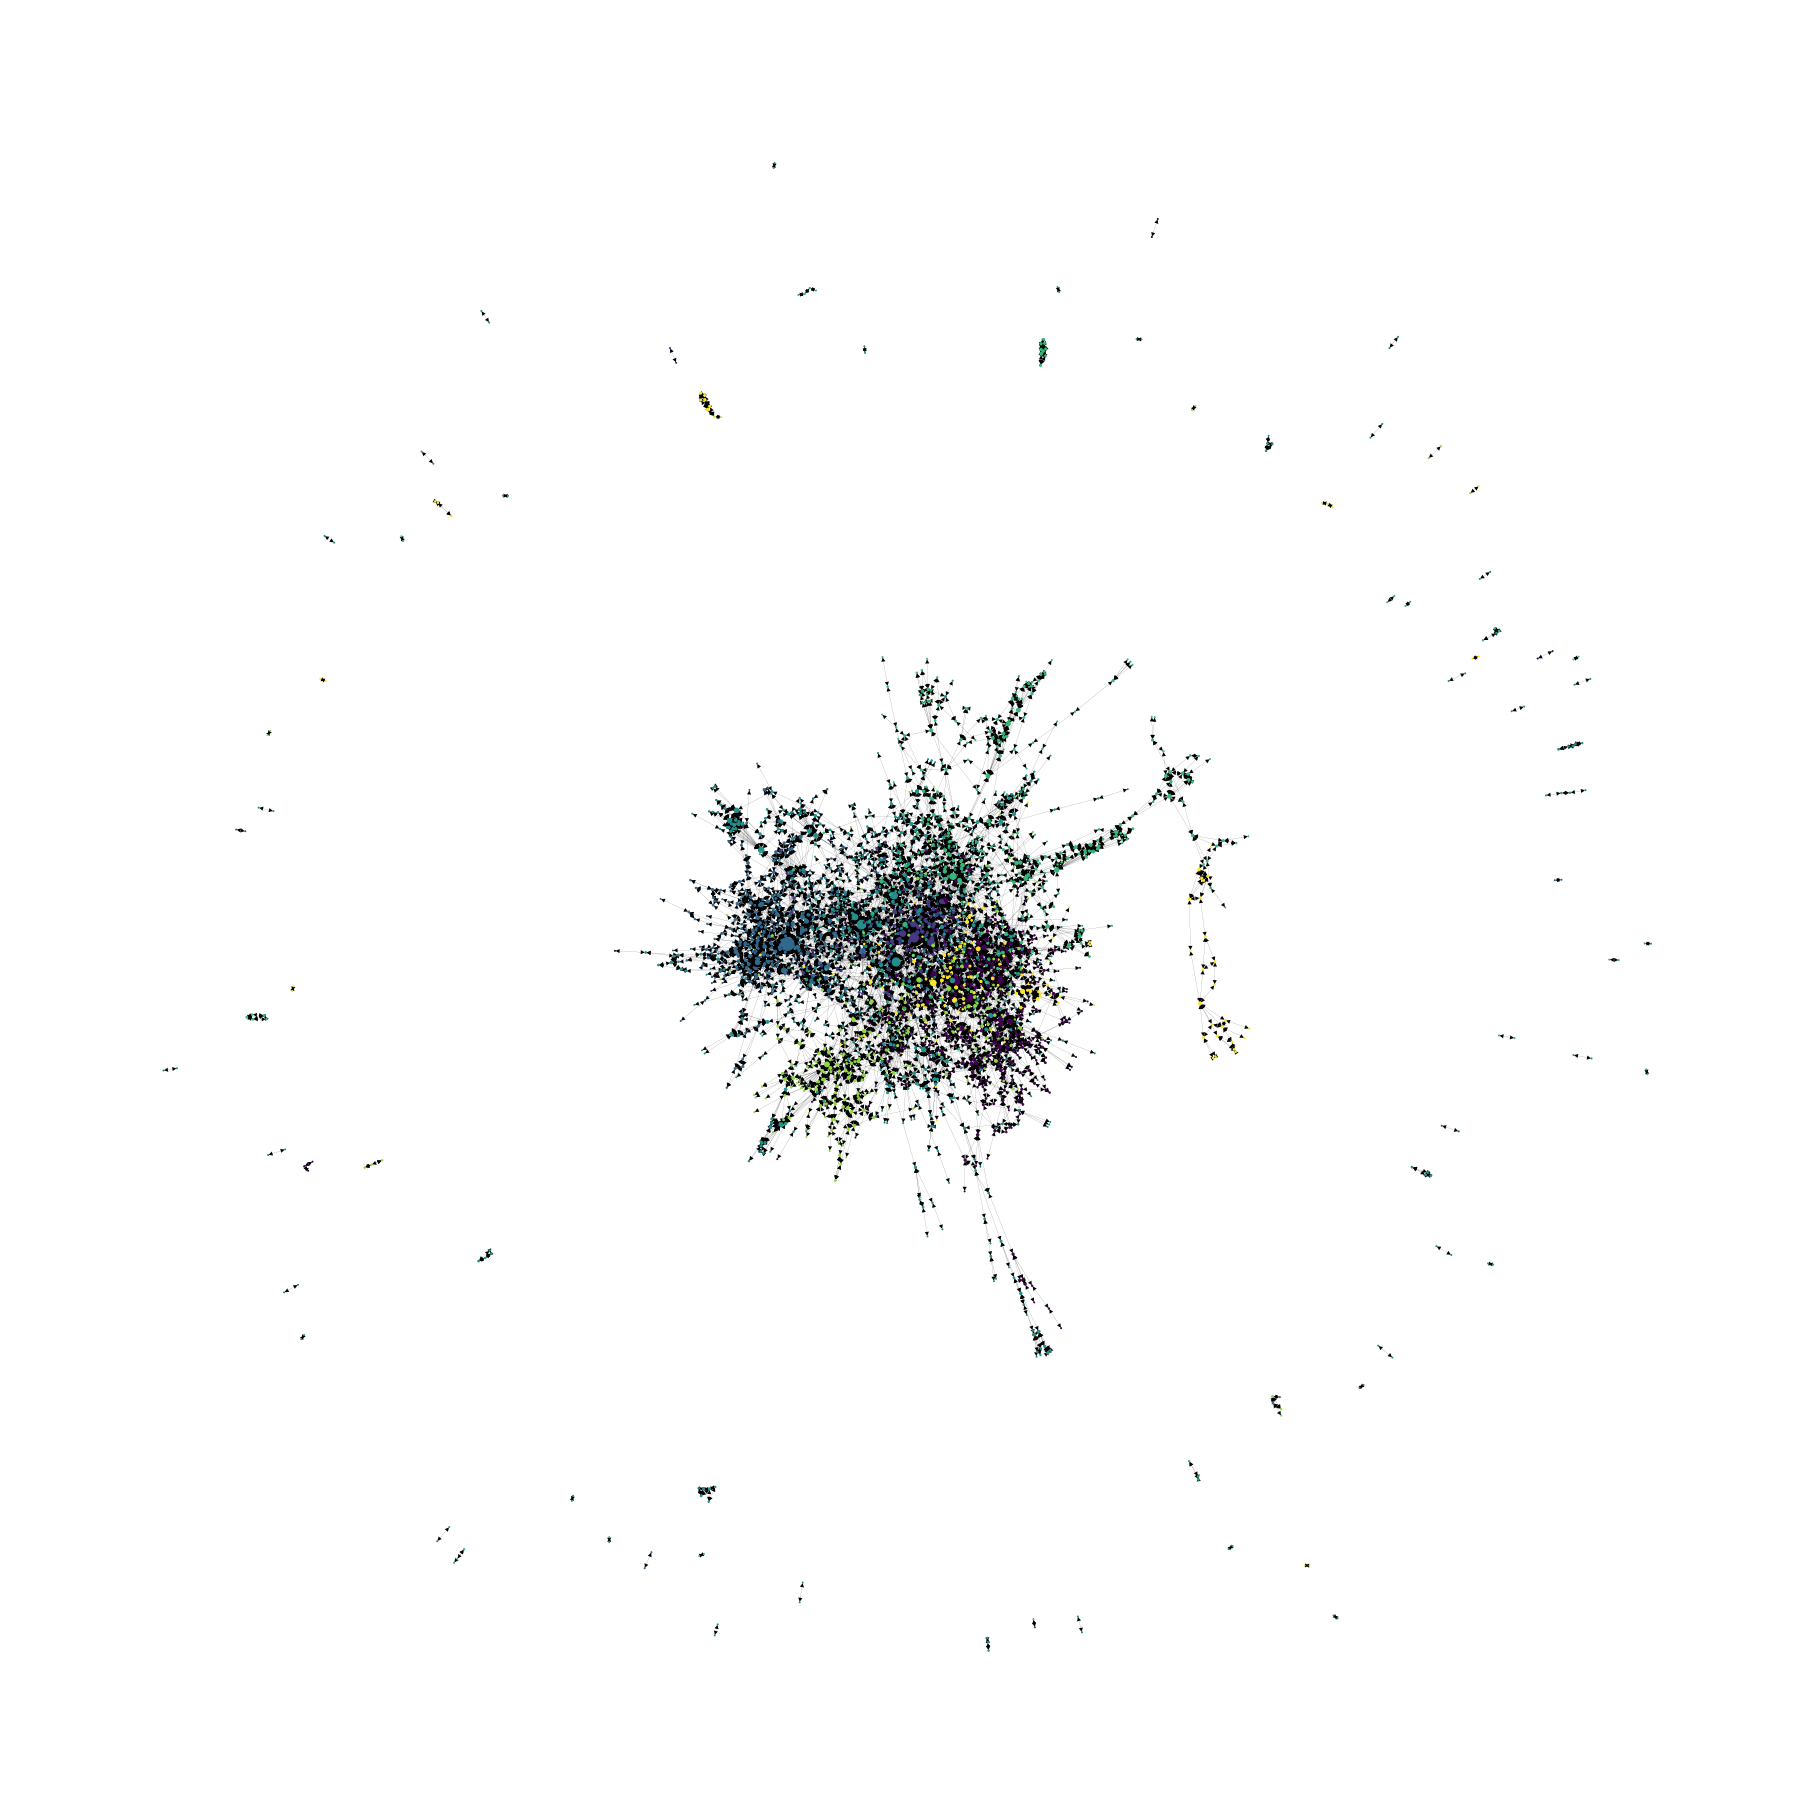

In [ ]:
plt.figure(1,figsize=(25,25)) 
nx.draw(g1.to_networkx(), alpha = 1, node_size = g1.in_degrees(), node_color = g1.ndata['label'], width=0.05)
plt.show()

### Generated

In [ ]:
g0_synth = gen_synthetic_graph_spectral(g1,h=1,d_out=g1.in_degrees().float().mean())

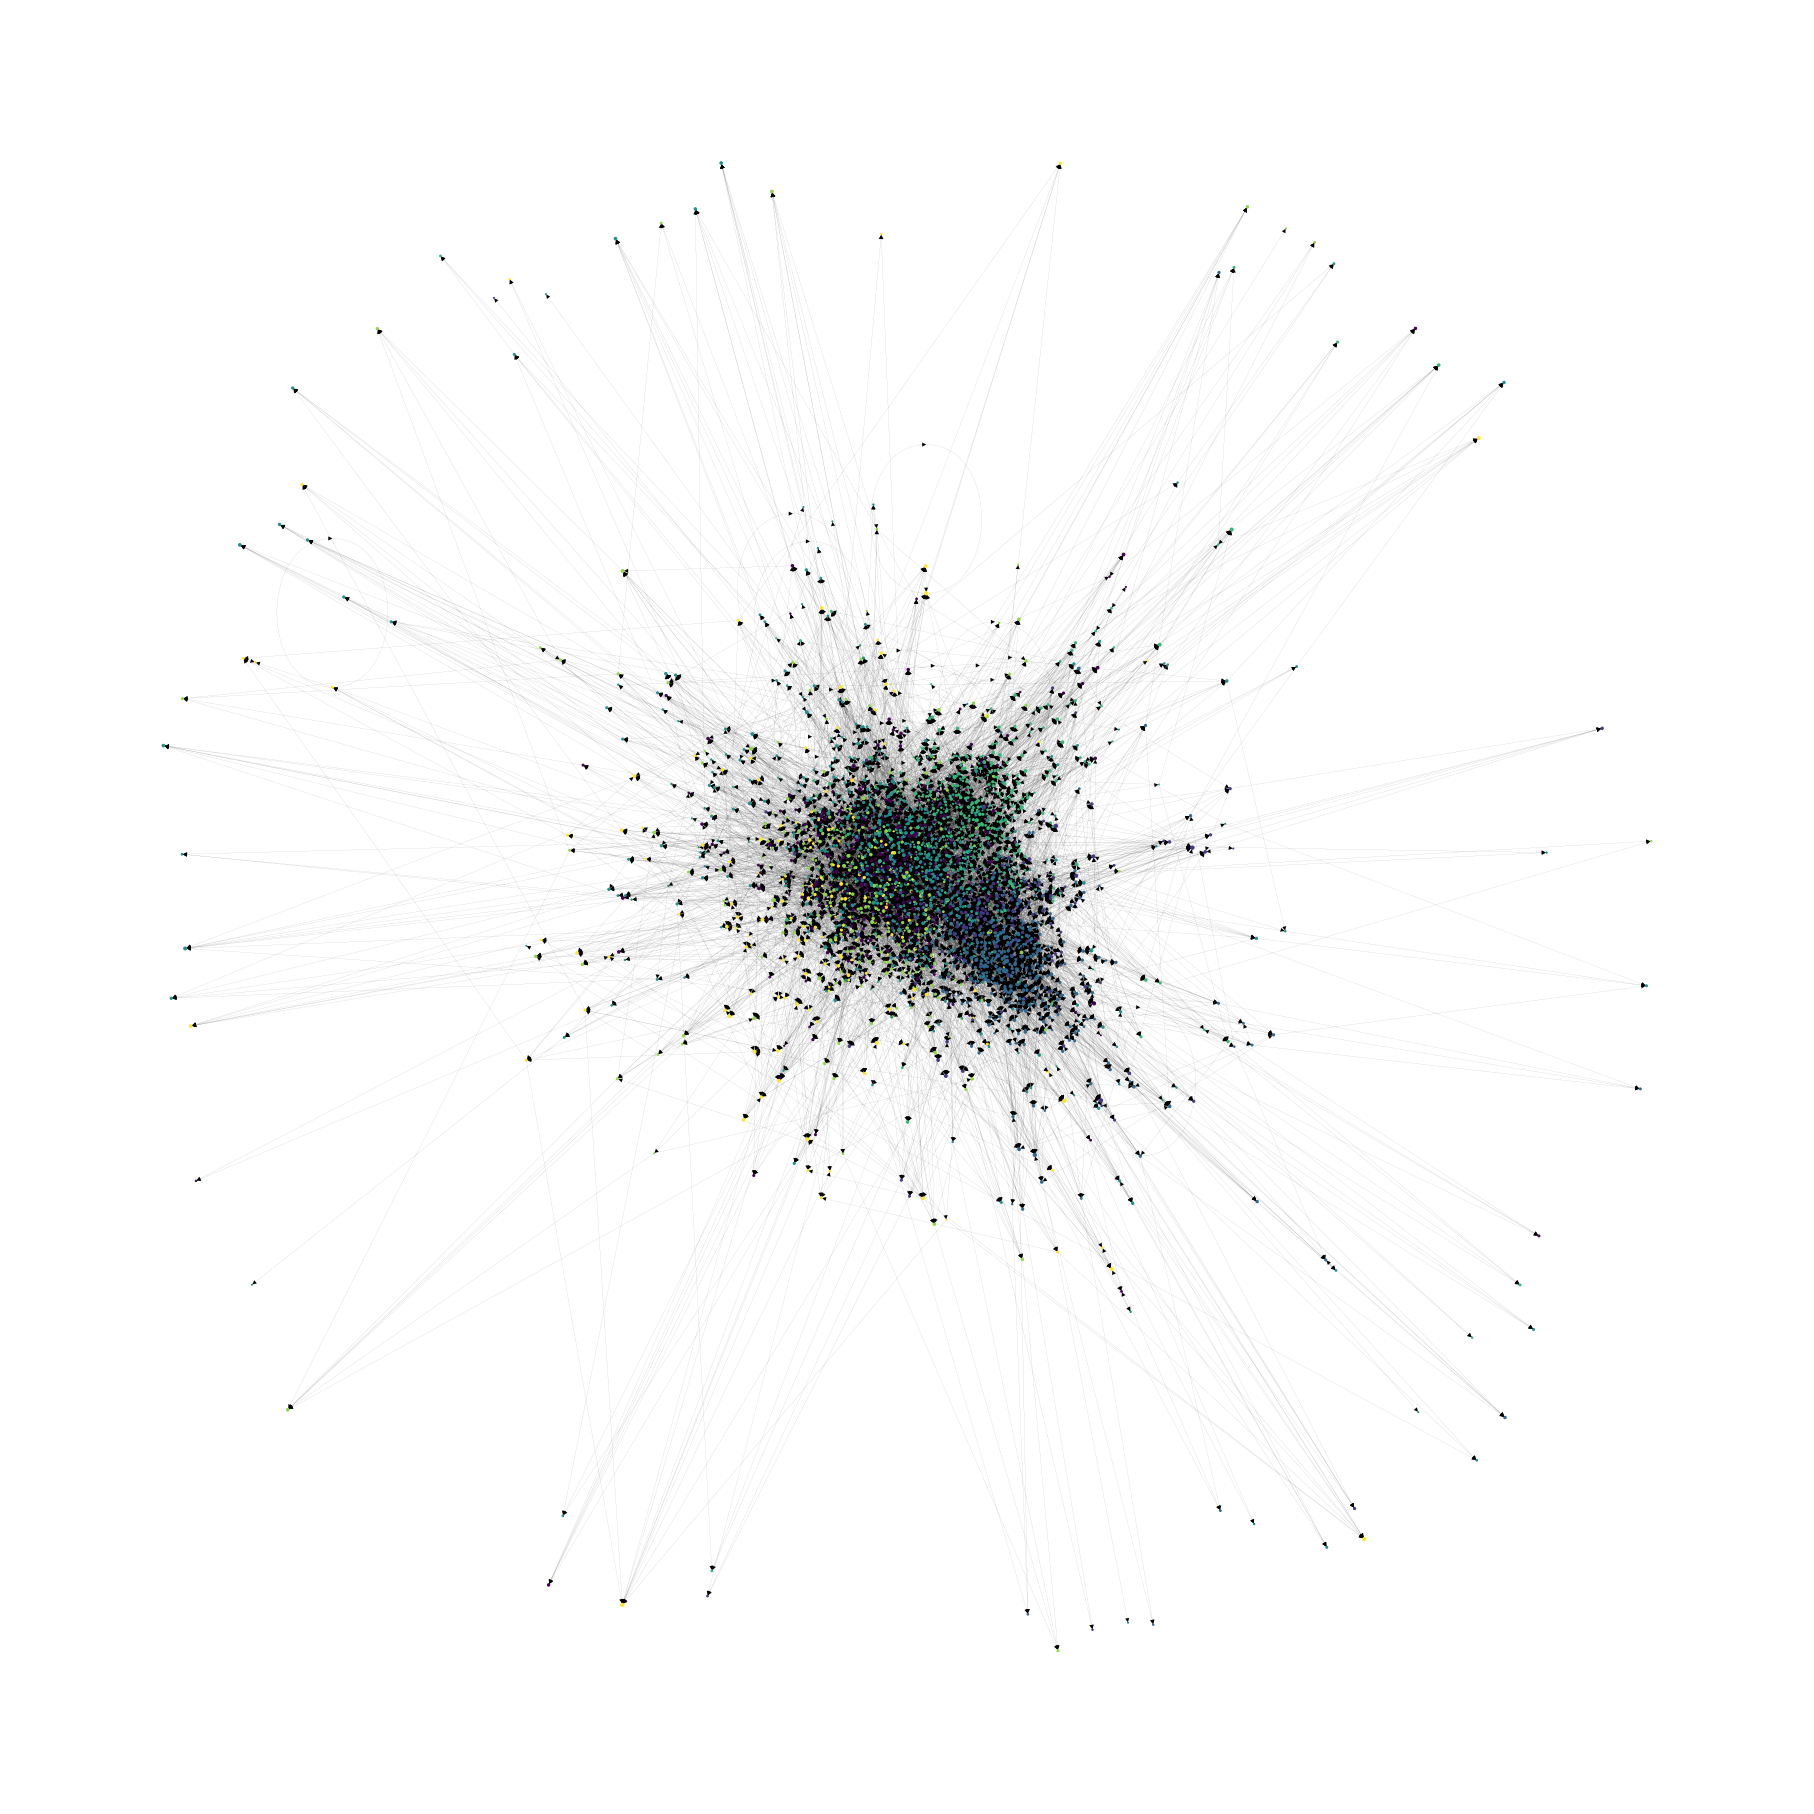

In [ ]:
plt.figure(1,figsize=(25,25)) 
nx.draw(g0_synth.to_networkx(), alpha = 1, node_size = g0_synth.in_degrees(), node_color = g0_synth.ndata['label'], width=0.05)
plt.show()

## Graph Summaries

In [75]:
graph_summary([g0_homo,g0_hetero,g1,g2,g3,g4,g5,g6])

==================================================(GRAPH 1)==================================================
Eigenvalues:  [4.0, 7.0, 7.0, 7.0, 8.0, 8.0, 10.0, 12.0, 12.0, 15.0]
Leading Eigenvalue:  15.0
Mean Degree:  9.9399995803833
Class Dist:  [0.09 0.08 0.09 0.05 0.16 0.08 0.11 0.13 0.08 0.13]
Edge Homophily:  1.0000001192092896
Class Normalised Homophily:  0.9054326415061951
==================================================(GRAPH 2)==================================================
Eigenvalues:  [-24.266542, -18.013777, -13.999999, -8.000013, -8.0, -8.0, -6.064083, -4.8011184, -1.3157475, 92.461235]
Leading Eigenvalue:  92.46123504638672
Mean Degree:  89.0999984741211
Class Dist:  [0.13 0.08 0.08 0.12 0.06 0.14 0.08 0.08 0.15 0.08]
Edge Homophily:  0.0
Class Normalised Homophily:  0.0
==================================================(GRAPH 3)==================================================
Eigenvalues:  [2.4093044, 2.6427934, 2.8226871, 3.0046778, 3.4439883, 3.7103155, 4.3167

## Geodesics

In [77]:
S,B,Pi = sbm_MLE(g1)

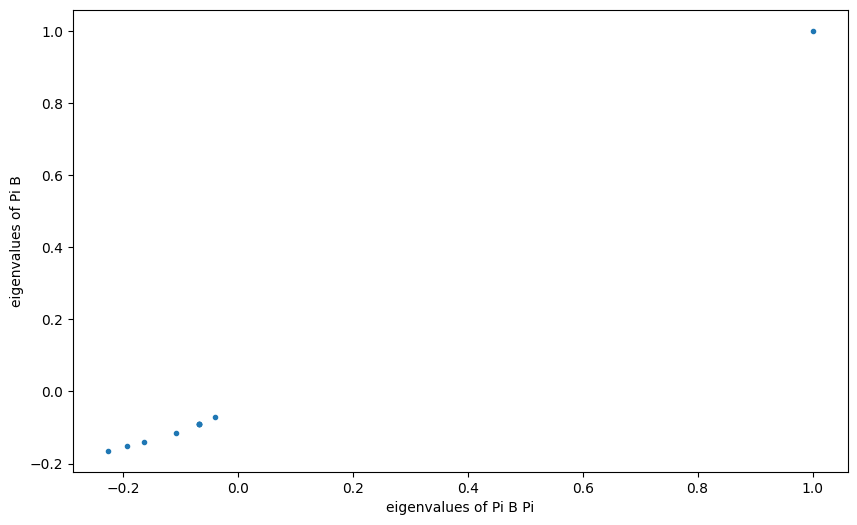

In [105]:
# calculate the eigenvalues of the matrix Pi B Pi
# calculate the eigenvalues of the matrix Pi B
# compare the eigenvalues of the two matrices

def compare_eigenvalues(g):
    S,B,Pi = sbm_MLE(g)
    eigvals1 = np.linalg.eigvals(Pi@B@Pi)
    eigvals2 = np.linalg.eigvals(Pi@B)
    #sort eigvals
    idx1 = np.argsort(eigvals1)
    idx2 = np.argsort(eigvals2)
    eigvals1 = eigvals1[idx1]
    eigvals2 = eigvals2[idx2]
    # normalize by the leading eigenvalue
    eigvals1 = eigvals1/eigvals1[-1]
    eigvals2 = eigvals2/eigvals2[-1]
    fig = plt.figure(figsize=(10,6))
    plt.plot(eigvals1,eigvals2,'.')
    plt.xlabel('eigenvalues of Pi B Pi')
    plt.ylabel('eigenvalues of Pi B')
    plt.show()
    return
compare_eigenvalues(g0_hetero)

In [108]:
intra_class_mean_spl(g0_hetero)

1.7819963369963372

In [109]:
intra_class_mean_spl(g0_homo)

0.8895522533022533

In [ ]:
mean_spl_list1,mean_intra_spl_list1,mean_eigenvalue_list1,g1_list = simulate_geodesics_homophily(g1,k=40)

100%|██████████| 80/80 [37:57<00:00, 28.47s/it]


In [ ]:
torch.save(g1_list,'g1_list')
torch.save(mean_spl_list1,'mean_spl_list1')
torch.save(mean_intra_spl_list1,'mean_intra_spl_list1')
torch.save(mean_eigenvalue_list1,'mean_eigenvalue_list1')

In [ ]:
torch.load('testing')

[Graph(num_nodes=2708, num_edges=7321,
       ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
       edata_schemes={}), Graph(num_nodes=2708, num_edges=9127,
       ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
       edata_schemes={})]